In [1]:
%load_ext autoreload
%autoreload 2

import os
ROOT_DIR = os.getcwd()[:os.getcwd().rfind('NVcenter')]+ 'NVcenter'
os.chdir(ROOT_DIR)

In [2]:
import qDNA
import qutip as q
import numpy as np
from NVcenter import *

# targets
H_gate = q.tensor( q.qeye(2), 1/np.sqrt(2) * (q.sigmax() + q.sigmaz()) )
CNOT_gate = q.tensor( q.fock_dm(2,0), q.qeye(2) ) + q.tensor( q.fock_dm(2,1), q.sigmax() )
init_state = q.tensor( q.fock_dm(2,0), q.fock_dm(2,0) )
H_state = H_gate * init_state * H_gate.dag()
CNOT_state = CNOT_gate * init_state * CNOT_gate.dag()

# C13 spins  with the correct factor 2pi
# Suter_C13_1 = (4.722331100730915e-10, 0.0, 1.030637866442101e-10)
# Suter_C13_2 = (3.6747967115510627e-10, 0.0, 1.4217244863175118e-10)
# Suter_C13_3 = (4.1283485801972827e-10, 0.0, 8.964851198130749e-11)
# Suter_C13_4 = (3.6919326714940366e-10, 0.0, 8.849893347694991e-11)

# pulse sequences
# pulse_seq = [0e-6, 4.06e-6, 1.57e-6, 1.51e-6, 1.00, 3.58, 1.68, 0.69, 1.97, 0.50] # Dominik Hadamard
# pulse_seq = [0.74e-6, 0.22e-6, 0.43e-6, 0.89e-6, 0.23e-6, 1.26e-6, 1.50e-6, 3*np.pi/2, 3*np.pi/2, np.pi/2] # Suter Hadamard 
# pulse_seq = [3.78e-6, 2.11e-6, 2.15e-6, 0.63e-6, 1.88e-6, 3.96e-6, 1.9e-6, 0, np.pi/5, np.pi/2] # Suter CNOT

# Suter simple Hadamard

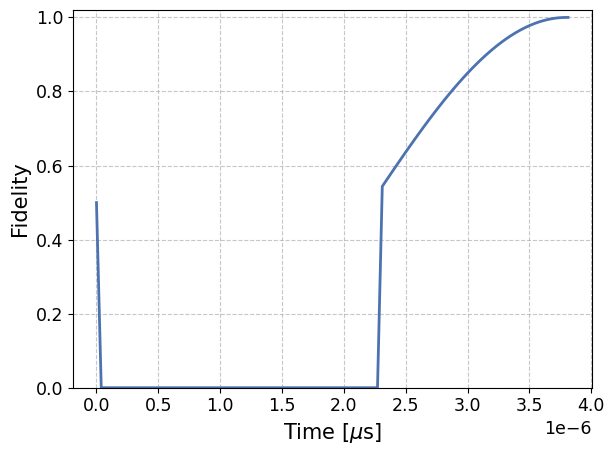

In [13]:
Suter_C13_1 = (4.722331100730915e-10, 0.0, 1.030637866442101e-10)
register_config = [('NV', (0, 0, 0), 0, {}), ('C13', Suter_C13_1, 0, {})]
bath_config = SpinBath('C13', 1.1e-2, 0.5e-9, 0.9e-9).config
approx_level = 'no_bath'
old_state = q.tensor(q.fock_dm(2,0), q.fock_dm(2,0))
pulse_seq = [0, 2.28e-6, 1.53e-6, 1e-9, 1e-9, 0, 0]
target = q.tensor(q.fock_dm(2,0), q.Qobj(np.ones((2,2)))*0.5)

evaluation = Evaluation(old_state, pulse_seq, register_config, [bath_config], approx_level=approx_level, target=target)

t_list = np.linspace(0, evaluation.total_time, 100)
new_states = evaluation.get_new_states(t_list)
new_fidelities = evaluation.get_new_fidelities(new_states)

fig, ax = plt.subplots()
ax.plot(t_list, new_fidelities)

# plot settings
ax.set_ylabel('Fidelity')
ax.set_xlabel(r'Time [$\mu$s]')
ax.set_ylim(0,1.02)
plt.show()

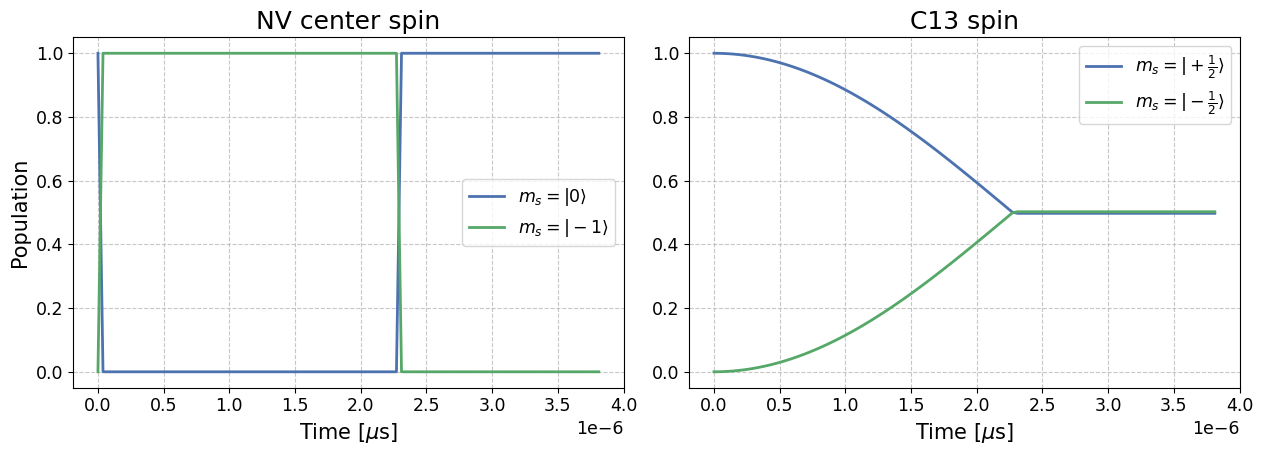

In [16]:
Suter_C13_1 = (4.722331100730915e-10, 0.0, 1.030637866442101e-10)
register_config = [('NV', (0, 0, 0), 0, {}), ('C13', Suter_C13_1, 0, {})]
bath_config = SpinBath('C13', 1.1e-2, 0.5e-9, 0.9e-9).config
approx_level = 'no_bath'
old_state = q.tensor(q.fock_dm(2,0), q.fock_dm(2,0))
pulse_seq = [0, 2.28e-6, 1.53e-6, 1e-9, 1e-9, 0, 0]
target = q.tensor(q.Qobj(np.ones((2,2)))*0.5, q.fock_dm(2,0))

evaluation = Evaluation(old_state, pulse_seq, register_config, [bath_config], approx_level=approx_level, target=target)

t_list = np.linspace(0, evaluation.total_time, 100)
new_states = evaluation.get_new_states(t_list)
C13_pops = [q.ptrace(new_state, 1).diag() for new_state in new_states]
NV_pops = [q.ptrace(new_state, 0).diag() for new_state in new_states]

fig, ax = plt.subplots(1, 2, figsize=(6.4*2, 4.8))
ax[0].plot(t_list, [NV_pop[0] for NV_pop in NV_pops], label=r'$m_s=|0\rangle$')
ax[0].plot(t_list, [NV_pop[1] for NV_pop in NV_pops], label=r'$m_s=|-1\rangle$')

ax[1].plot(t_list, [C13_pop[0] for C13_pop in C13_pops], label=r'$m_s=|+\frac{1}{2}\rangle$')
ax[1].plot(t_list, [C13_pop[1] for C13_pop in C13_pops], label=r'$m_s=|-\frac{1}{2}\rangle$')

# plot settings
ax[0].legend()
ax[1].legend()
ax[0].set_title('NV center spin')
ax[1].set_title('C13 spin')
ax[0].set_ylabel('Population')
ax[0].set_xlabel(r'Time [$\mu$s]')
ax[1].set_xlabel(r'Time [$\mu$s]')
plt.show()

# Suter Hadamard

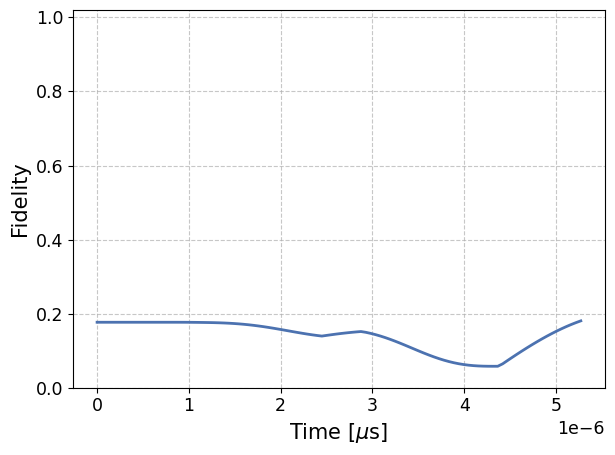

In [79]:
Suter_C13_1 = (4.722331100730915e-10, 0.0, 1.030637866442101e-10)
register_config = [('NV', (0, 0, 0), 0, {}), ('C13', Suter_C13_1, 0, {})]
bath_config = SpinBath('C13', 1.1e-2, 0.5e-9, 0.9e-9).config
approx_level = 'no_bath'
old_state = q.tensor(q.fock_dm(2,0), q.fock_dm(2,0))
pulse_seq = [0.74e-6, 0.22e-6, 0.43e-6, 0.89e-6, 0.23e-6, 1.26e-6, 1.50e-6, 3*np.pi/2, 3*np.pi/2, np.pi/2] # Suter Hadamard 
#pulse_seq = [0.74e-6, 0.22e-6, 0.43e-6, 0.89e-6, 0.23e-6, 1.26e-6, 1.50e-6, 3*np.sqrt(2)*np.pi/2, np.sqrt(2)*3*np.pi/2, np.sqrt(2)*np.pi/2] # Suter Hadamard 
target = q.tensor( q.qeye(2), 1/np.sqrt(2) * (q.sigmax() + q.sigmaz()) )

evaluation = Evaluation(old_state, pulse_seq, register_config, [bath_config], approx_level=approx_level, target=target)

t_list = np.linspace(0, evaluation.total_time, 100)
new_states = evaluation.get_new_states(t_list)
new_fidelities = evaluation.get_new_fidelities(new_states)

fig, ax = plt.subplots()
ax.plot(t_list, new_fidelities)

# plot settings
ax.set_ylabel('Fidelity')
ax.set_xlabel(r'Time [$\mu$s]')
ax.set_ylim(0,1.02)
plt.show()

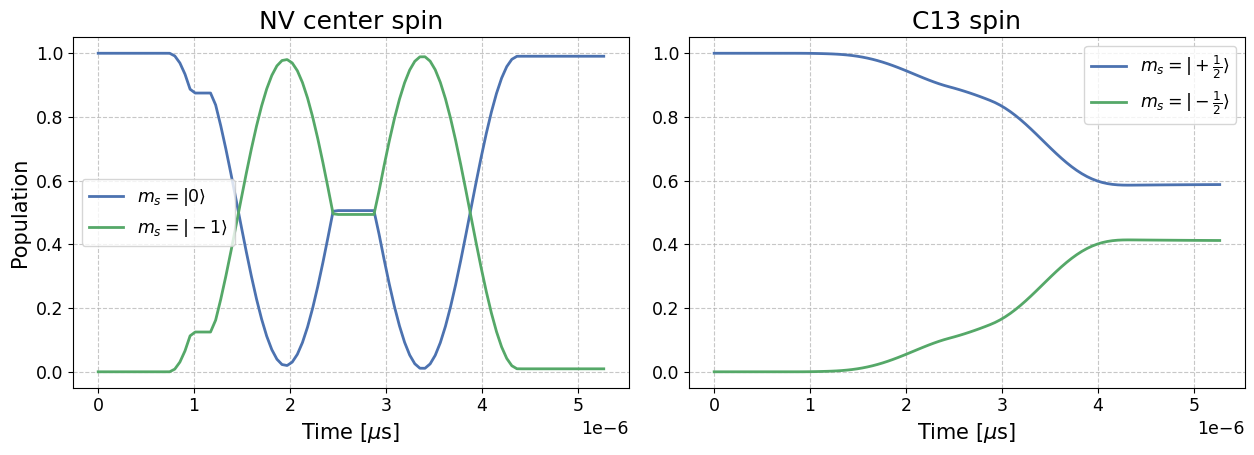

In [4]:
Suter_C13_1 = (4.722331100730915e-10, 0.0, 1.030637866442101e-10)
register_config = [('NV', (0, 0, 0), 0, {}), ('C13', Suter_C13_1, 0, {})]
bath_config = SpinBath('C13', 1.1e-2, 0.5e-9, 0.9e-9).config
approx_level = 'no_bath'
old_state = q.tensor(q.fock_dm(2,0), q.fock_dm(2,0))
pulse_seq = [0.74e-6, 0.22e-6, 0.43e-6, 0.89e-6, 0.23e-6, 1.26e-6, 1.50e-6, 3*np.pi/2, 3*np.pi/2, np.pi/2] # Suter Hadamard 
#pulse_seq = [0.74e-6, 0.22e-6, 0.43e-6, 0.89e-6, 0.23e-6, 1.26e-6, 1.50e-6, 3*np.sqrt(2)*np.pi/2, np.sqrt(2)*3*np.pi/2, np.sqrt(2)*np.pi/2] # Suter Hadamard 

evaluation = Evaluation(old_state, pulse_seq, register_config, [bath_config], approx_level=approx_level)

t_list = np.linspace(0, evaluation.total_time, 100)
new_states = evaluation.get_new_states(t_list)
C13_pops = [q.ptrace(new_state, 1).diag() for new_state in new_states]
NV_pops = [q.ptrace(new_state, 0).diag() for new_state in new_states]

fig, ax = plt.subplots(1, 2, figsize=(6.4*2, 4.8))
ax[0].plot(t_list, [NV_pop[0] for NV_pop in NV_pops], label=r'$m_s=|0\rangle$')
ax[0].plot(t_list, [NV_pop[1] for NV_pop in NV_pops], label=r'$m_s=|-1\rangle$')

ax[1].plot(t_list, [C13_pop[0] for C13_pop in C13_pops], label=r'$m_s=|+\frac{1}{2}\rangle$')
ax[1].plot(t_list, [C13_pop[1] for C13_pop in C13_pops], label=r'$m_s=|-\frac{1}{2}\rangle$')

# plot settings
ax[0].legend()
ax[1].legend()
ax[0].set_title('NV center spin')
ax[1].set_title('C13 spin')
ax[0].set_ylabel('Population')
ax[0].set_xlabel(r'Time [$\mu$s]')
ax[1].set_xlabel(r'Time [$\mu$s]')
plt.show()

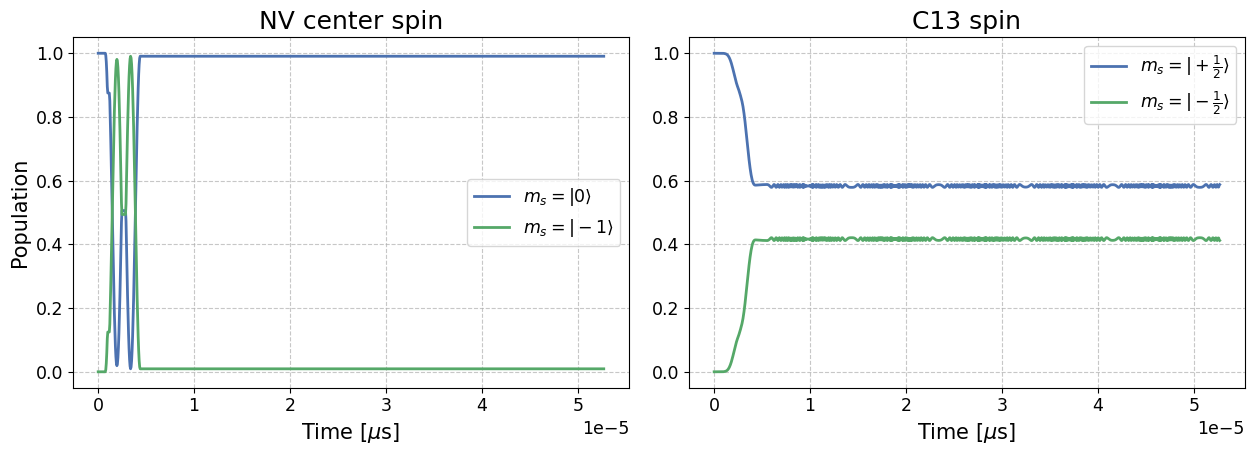

In [85]:
Suter_C13_1 = (4.722331100730915e-10, 0.0, 1.030637866442101e-10)
register_config = [('NV', (0, 0, 0), 0, {}), ('C13', Suter_C13_1, 0, {})]
bath_config = SpinBath('C13', 1.1e-2, 0.5e-9, 0.9e-9).config
approx_level = 'no_bath'
old_state = q.tensor(q.fock_dm(2,0), q.fock_dm(2,0))
pulse_seq = [0.74e-6, 0.22e-6, 0.43e-6, 0.89e-6, 0.23e-6, 1.26e-6, 1.50e-6, 3*np.pi/2, 3*np.pi/2, np.pi/2] # Suter Hadamard 
#pulse_seq = [0.74e-6, 0.22e-6, 0.43e-6, 0.89e-6, 0.23e-6, 1.26e-6, 1.50e-6, 3*np.sqrt(2)*np.pi/2, np.sqrt(2)*3*np.pi/2, np.sqrt(2)*np.pi/2] # Suter Hadamard 

evaluation = Evaluation(old_state, pulse_seq, register_config, [bath_config], approx_level=approx_level)

t_list = np.linspace(0, 10*evaluation.total_time, 1000)
new_states = evaluation.get_new_states(t_list)
C13_pops = [q.ptrace(new_state, 1).diag() for new_state in new_states]
NV_pops = [q.ptrace(new_state, 0).diag() for new_state in new_states]

fig, ax = plt.subplots(1, 2, figsize=(6.4*2, 4.8))
ax[0].plot(t_list, [NV_pop[0] for NV_pop in NV_pops], label=r'$m_s=|0\rangle$')
ax[0].plot(t_list, [NV_pop[1] for NV_pop in NV_pops], label=r'$m_s=|-1\rangle$')

ax[1].plot(t_list, [C13_pop[0] for C13_pop in C13_pops], label=r'$m_s=|+\frac{1}{2}\rangle$')
ax[1].plot(t_list, [C13_pop[1] for C13_pop in C13_pops], label=r'$m_s=|-\frac{1}{2}\rangle$')

# plot settings
ax[0].legend()
ax[1].legend()
ax[0].set_title('NV center spin')
ax[1].set_title('C13 spin')
ax[0].set_ylabel('Population')
ax[0].set_xlabel(r'Time [$\mu$s]')
ax[1].set_xlabel(r'Time [$\mu$s]')
plt.show()

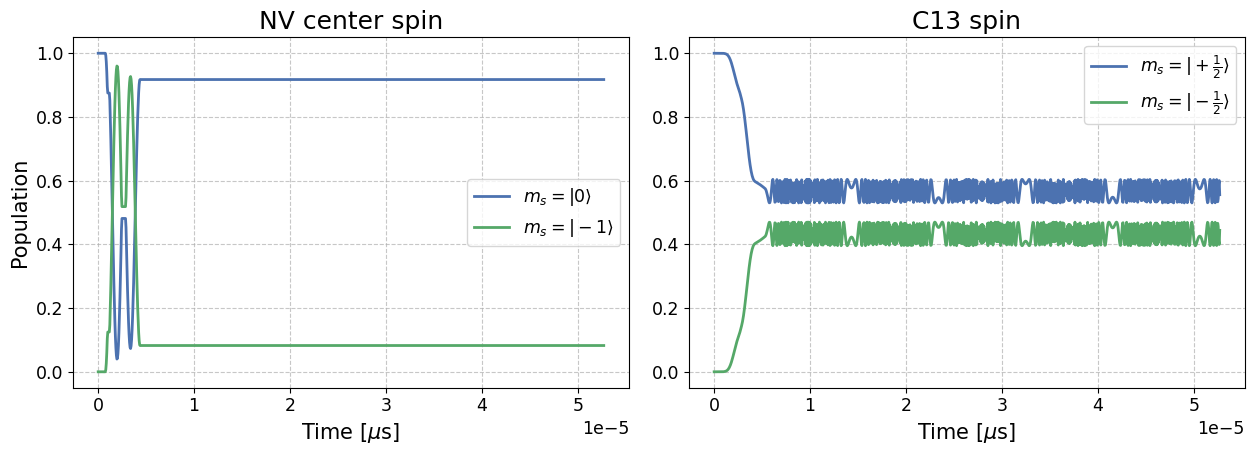

In [86]:
Suter_C13_1 = (4.722331100730915e-10, 0.0, 1.030637866442101e-10)
register_config = [('NV', (0, 0, 0), 0, {}), ('C13', Suter_C13_1, 0, {})]
bath_config = SpinBath('C13', 1.1e-2, 0.5e-9, 0.9e-9).config
approx_level = 'gCCE0'
old_state = q.tensor(q.fock_dm(2,0), q.fock_dm(2,0))
pulse_seq = [0.74e-6, 0.22e-6, 0.43e-6, 0.89e-6, 0.23e-6, 1.26e-6, 1.50e-6, 3*np.pi/2, 3*np.pi/2, np.pi/2] # Suter Hadamard 
#pulse_seq = [0.74e-6, 0.22e-6, 0.43e-6, 0.89e-6, 0.23e-6, 1.26e-6, 1.50e-6, 3*np.sqrt(2)*np.pi/2, np.sqrt(2)*3*np.pi/2, np.sqrt(2)*np.pi/2] # Suter Hadamard 

evaluation = Evaluation(old_state, pulse_seq, register_config, [bath_config], approx_level=approx_level)

t_list = np.linspace(0, 10*evaluation.total_time, 1000)
new_states = evaluation.get_new_states(t_list)
C13_pops = [q.ptrace(new_state, 1).diag() for new_state in new_states]
NV_pops = [q.ptrace(new_state, 0).diag() for new_state in new_states]

fig, ax = plt.subplots(1, 2, figsize=(6.4*2, 4.8))
ax[0].plot(t_list, [NV_pop[0] for NV_pop in NV_pops], label=r'$m_s=|0\rangle$')
ax[0].plot(t_list, [NV_pop[1] for NV_pop in NV_pops], label=r'$m_s=|-1\rangle$')

ax[1].plot(t_list, [C13_pop[0] for C13_pop in C13_pops], label=r'$m_s=|+\frac{1}{2}\rangle$')
ax[1].plot(t_list, [C13_pop[1] for C13_pop in C13_pops], label=r'$m_s=|-\frac{1}{2}\rangle$')

# plot settings
ax[0].legend()
ax[1].legend()
ax[0].set_title('NV center spin')
ax[1].set_title('C13 spin')
ax[0].set_ylabel('Population')
ax[0].set_xlabel(r'Time [$\mu$s]')
ax[1].set_xlabel(r'Time [$\mu$s]')
plt.show()

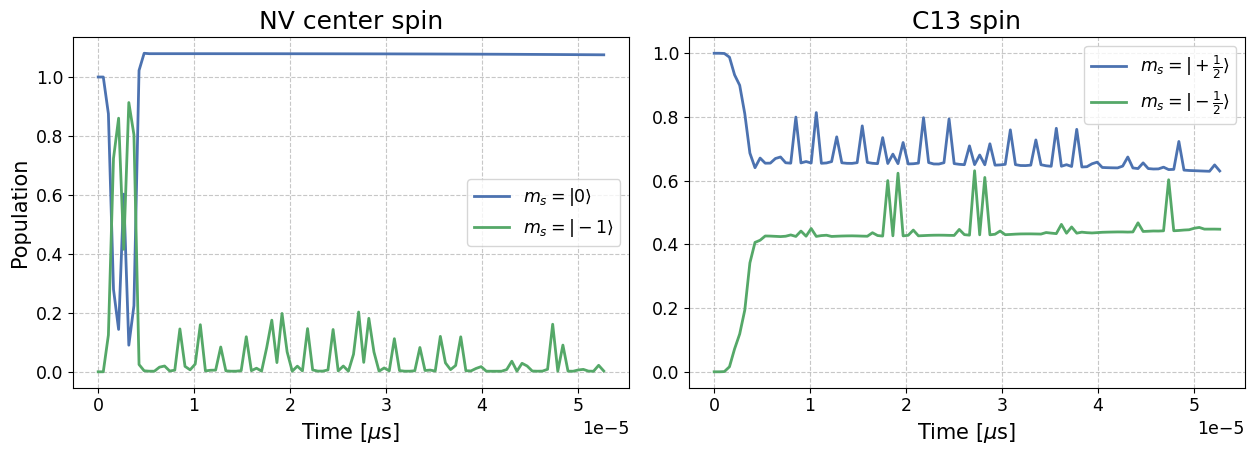

In [88]:
Suter_C13_1 = (4.722331100730915e-10, 0.0, 1.030637866442101e-10)
register_config = [('NV', (0, 0, 0), 0, {}), ('C13', Suter_C13_1, 0, {})]
bath_config = SpinBath('C13', 1.1e-2, 0.5e-9, 0.9e-9).config
approx_level = 'gCCE1'
old_state = q.tensor(q.fock_dm(2,0), q.fock_dm(2,0))
pulse_seq = [0.74e-6, 0.22e-6, 0.43e-6, 0.89e-6, 0.23e-6, 1.26e-6, 1.50e-6, 3*np.pi/2, 3*np.pi/2, np.pi/2] # Suter Hadamard 
#pulse_seq = [0.74e-6, 0.22e-6, 0.43e-6, 0.89e-6, 0.23e-6, 1.26e-6, 1.50e-6, 3*np.sqrt(2)*np.pi/2, np.sqrt(2)*3*np.pi/2, np.sqrt(2)*np.pi/2] # Suter Hadamard 

evaluation = Evaluation(old_state, pulse_seq, register_config, [bath_config], approx_level=approx_level)

t_list = np.linspace(0, 10*evaluation.total_time, 100)
new_states = evaluation.get_new_states(t_list)
C13_pops = [q.ptrace(new_state, 1).diag() for new_state in new_states]
NV_pops = [q.ptrace(new_state, 0).diag() for new_state in new_states]

fig, ax = plt.subplots(1, 2, figsize=(6.4*2, 4.8))

ax[0].plot(t_list, [NV_pop[0] for NV_pop in NV_pops], label=r'$m_s=|0\rangle$')
ax[0].plot(t_list, [NV_pop[1] for NV_pop in NV_pops], label=r'$m_s=|-1\rangle$')

ax[1].plot(t_list, [C13_pop[0] for C13_pop in C13_pops], label=r'$m_s=|+\frac{1}{2}\rangle$')
ax[1].plot(t_list, [C13_pop[1] for C13_pop in C13_pops], label=r'$m_s=|-\frac{1}{2}\rangle$')

# plot settings
ax[0].legend()
ax[1].legend()
ax[0].set_title('NV center spin')
ax[1].set_title('C13 spin')
ax[0].set_ylabel('Population')
ax[0].set_xlabel(r'Time [$\mu$s]')
ax[1].set_xlabel(r'Time [$\mu$s]')
plt.show()

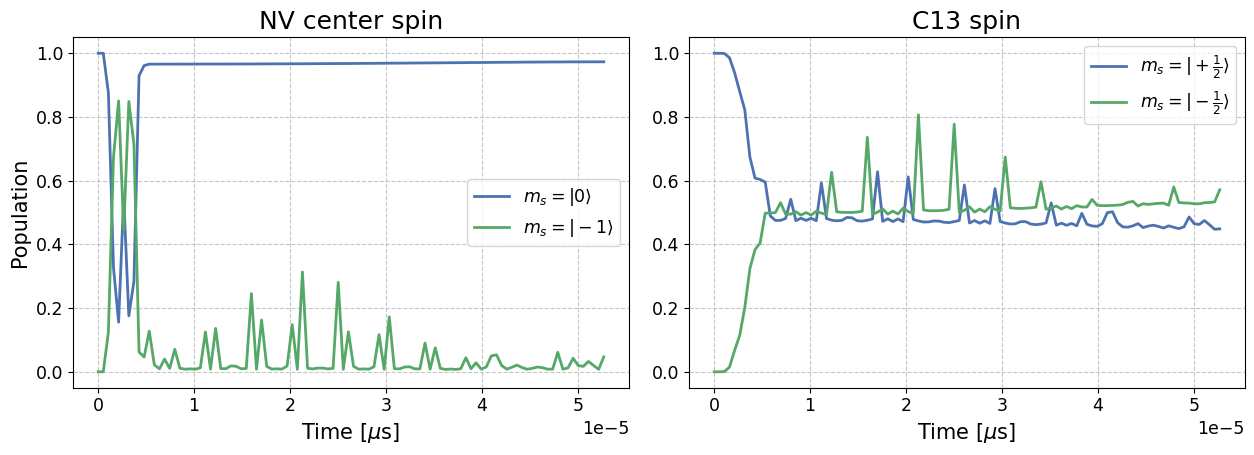

In [89]:
Suter_C13_1 = (4.722331100730915e-10, 0.0, 1.030637866442101e-10)
register_config = [('NV', (0, 0, 0), 0, {}), ('C13', Suter_C13_1, 0, {})]
bath_config = SpinBath('C13', 1.1e-2, 0.5e-9, 0.9e-9).config
approx_level = 'gCCE2'
old_state = q.tensor(q.fock_dm(2,0), q.fock_dm(2,0))
pulse_seq = [0.74e-6, 0.22e-6, 0.43e-6, 0.89e-6, 0.23e-6, 1.26e-6, 1.50e-6, 3*np.pi/2, 3*np.pi/2, np.pi/2] # Suter Hadamard 
#pulse_seq = [0.74e-6, 0.22e-6, 0.43e-6, 0.89e-6, 0.23e-6, 1.26e-6, 1.50e-6, 3*np.sqrt(2)*np.pi/2, np.sqrt(2)*3*np.pi/2, np.sqrt(2)*np.pi/2] # Suter Hadamard 

evaluation = Evaluation(old_state, pulse_seq, register_config, [bath_config], approx_level=approx_level)

t_list = np.linspace(0, 10*evaluation.total_time, 100)
new_states = evaluation.get_new_states(t_list)
C13_pops = [q.ptrace(new_state, 1).diag() for new_state in new_states]
NV_pops = [q.ptrace(new_state, 0).diag() for new_state in new_states]

fig, ax = plt.subplots(1, 2, figsize=(6.4*2, 4.8))
ax[0].plot(t_list, [NV_pop[0] for NV_pop in NV_pops], label=r'$m_s=|0\rangle$')
ax[0].plot(t_list, [NV_pop[1] for NV_pop in NV_pops], label=r'$m_s=|-1\rangle$')

ax[1].plot(t_list, [C13_pop[0] for C13_pop in C13_pops], label=r'$m_s=|+\frac{1}{2}\rangle$')
ax[1].plot(t_list, [C13_pop[1] for C13_pop in C13_pops], label=r'$m_s=|-\frac{1}{2}\rangle$')

# plot settings
ax[0].legend()
ax[1].legend()
ax[0].set_title('NV center spin')
ax[1].set_title('C13 spin')
ax[0].set_ylabel('Population')
ax[0].set_xlabel(r'Time [$\mu$s]')
ax[1].set_xlabel(r'Time [$\mu$s]')
plt.show()

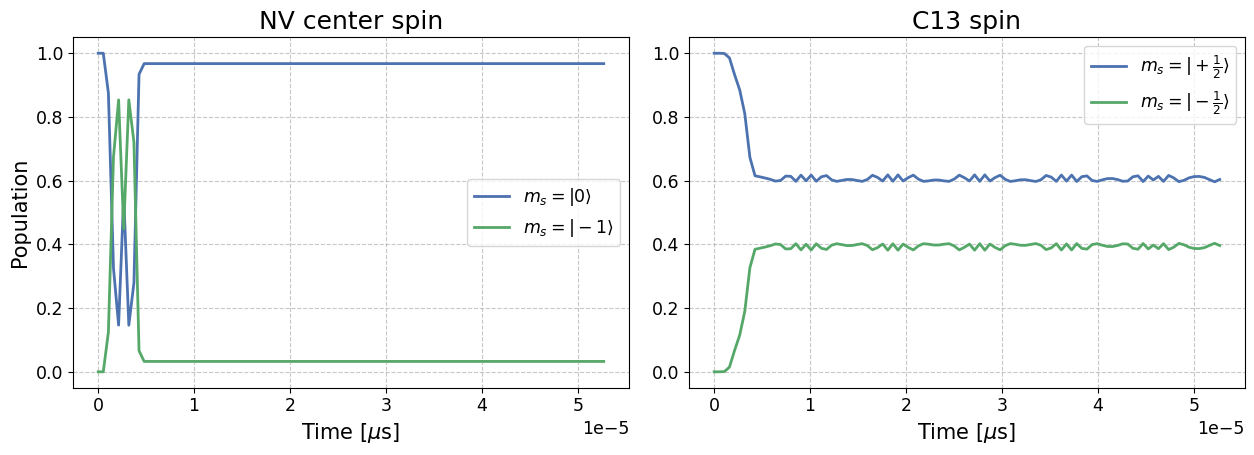

In [90]:
Suter_C13_1 = (4.722331100730915e-10, 0.0, 1.030637866442101e-10)
register_config = [('NV', (0, 0, 0), 0, {}), ('C13', Suter_C13_1, 0, {})]
bath_config = SpinBath('C13', 1.1e-2, 0.5e-9, 0.9e-9).config
approx_level = 'full_bath'
old_state = q.tensor(q.fock_dm(2,0), q.fock_dm(2,0))
pulse_seq = [0.74e-6, 0.22e-6, 0.43e-6, 0.89e-6, 0.23e-6, 1.26e-6, 1.50e-6, 3*np.pi/2, 3*np.pi/2, np.pi/2] # Suter Hadamard 
#pulse_seq = [0.74e-6, 0.22e-6, 0.43e-6, 0.89e-6, 0.23e-6, 1.26e-6, 1.50e-6, 3*np.sqrt(2)*np.pi/2, np.sqrt(2)*3*np.pi/2, np.sqrt(2)*np.pi/2] # Suter Hadamard 

evaluation = Evaluation(old_state, pulse_seq, register_config, [bath_config], approx_level=approx_level)

t_list = np.linspace(0, 10*evaluation.total_time, 100)
new_states = evaluation.get_new_states(t_list)
C13_pops = [q.ptrace(new_state, 1).diag() for new_state in new_states]
NV_pops = [q.ptrace(new_state, 0).diag() for new_state in new_states]

fig, ax = plt.subplots(1, 2, figsize=(6.4*2, 4.8))
ax[0].plot(t_list, [NV_pop[0] for NV_pop in NV_pops], label=r'$m_s=|0\rangle$')
ax[0].plot(t_list, [NV_pop[1] for NV_pop in NV_pops], label=r'$m_s=|-1\rangle$')

ax[1].plot(t_list, [C13_pop[0] for C13_pop in C13_pops], label=r'$m_s=|+\frac{1}{2}\rangle$')
ax[1].plot(t_list, [C13_pop[1] for C13_pop in C13_pops], label=r'$m_s=|-\frac{1}{2}\rangle$')

# plot settings
ax[0].legend()
ax[1].legend()
ax[0].set_title('NV center spin')
ax[1].set_title('C13 spin')
ax[0].set_ylabel('Population')
ax[0].set_xlabel(r'Time [$\mu$s]')
ax[1].set_xlabel(r'Time [$\mu$s]')
plt.show()

## Reinforcement Learning

In [113]:
class Environment:
    def __init__(self, register_config, bath_config, approx, target, dynamical_decoupling=False):

        self.register_config = register_config
        self.bath_config = bath_config
        self.approx = approx
        self.target = target
        self.dynamical_decoupling = dynamical_decoupling

        self.hamiltonian = Hamiltonian(self.register_config, self.bath_config, 'no_bath')
        self.register_init_state = self.hamiltonian.register_init_state
        
        # reset emvironment
        self.state = self.register_init_state
        self.fidelity = calc_fidelity(self.state, self.target)

    def reset(self):
        self.state = self.init_state
        self.fidelity = calc_fidelity(self.state, self.target)

    def step(self, pulse_seq):
        if self.approx == 'gCCE':
            self.state = self.get_new_states_gCCE(pulse_seq, self.state, 2)
        else: 
            self.state = self.get_new_states(pulse_seq, self.state, self.approx)[0]
            
        self.fidelity = calc_fidelity(self.state, self.target)
        return self.state, self.fidelity
        

    def get_new_states(self, pulse_seq, old_state, approx_level):
        pulse = Pulse(pulse_seq, 
                      self.register_config, 
                      self.bath_config, 
                      approx_level, 
                      self.target, 
                      old_state=old_state, 
                      dynamical_decoupling=self.dynamical_decoupling)

        if approx_level == 'gCCE2':
            return pulse.new_states, pulse.idx_gCCE2
        return pulse.new_states
    
    def get_new_states_gCCE(self, pulse_seq, old_states, gCCE_order):
        gCCE0_dm = self.get_new_states(pulse_seq, old_states, 'gCCE0')[0]
        gCCE_dm = gCCE0_dm
        
        if gCCE_order == 0:
            return gCCE_dm
            
        gCCE1_dms = self.get_new_states(pulse_seq, old_states, 'gCCE1')
        gCCE_dm_correction = np.prod( [gCCE1_dm.full() / gCCE0_dm.full() for gCCE1_dm in gCCE1_dms], axis=0 )
        gCCE_dm_correction = q.Qobj(gCCE_dm, dims=[[2, 2], [2, 2]])
        gCCE_dm *= gCCE_dm_correction
        
        if gCCE_order == 1:
            return gCCE_dm
            
        gCCE2_dms, idx_gCCE2 = self.get_new_states(pulse_seq, old_states, 'gCCE2') 
        gCCE_dm_correction = np.prod( [(gCCE2_dm.full() * gCCE0_dm.full()) / (gCCE1_dms[i].full() * gCCE1_dms[j].full()) for gCCE2_dm, (i,j) in zip(gCCE2_dms, idx_gCCE2)], axis=0 )
        gCCE_dm_correction = q.Qobj(gCCE_dm, dims=[[2, 2], [2, 2]])
        gCCE_dm *= gCCE_dm_correction
        
        if gCCE_order == 2:
            return gCCE_dm
            
        else:
            return NotImplementedError

In [115]:
register_config = [('NV', (0, 0, 0), 0, {}), ('C13', (0.87e-9, 0, 0.19e-9), 0, {})]
bath_config = SpinBath('C13', 0.02e-2, 2e-9, 2.5e-9).config
approx = 'full_bath'

pulse_seq = [0e-6, 4.06e-6, 1.57e-6, 1.51e-6, 1.00, 3.58, 1.68, 0.69, 1.97, 0.50]
target = 1/np.sqrt(2) * (q.tensor(q.fock_dm(2,0), q.fock_dm(2,0)) + q.tensor(q.fock_dm(2,1), q.fock_dm(2,1)) )

env = Environment(register_config, bath_config, approx, target, dynamical_decoupling=False)
env.step(pulse_seq)[1]

0.4355367060849788